# Multi Criteria Decision Making (Ranking)



## Data handling

**Dataset**: https://github.com/RodolfoViana/exploratory-data-analysis-dataset-cars

Processing done:
1. Mapped 'price' from cars_price.csv
2. Create a unique car identifier column 'car_name_model' by concat(car_name, model). For two cars added {_1, _2} additional identifier.

Data description: (only relevant cols)

- MPG: A measure of how far a car can travel if you put just one gallon of petrol or diesel in its tank.
- Acceleration: measure of how long it takes the car to reach a speed from 0. Higher the acceleration, better the car for drag racing
- Price: Manufacturer retail price
- Weight: Weight of the car
- Displacement: Engine displacement is the measure of the cylinder volume swept by all of the pistons of a piston engine. More displacement means more power.

In [ ]:
!pip install scikit-criteria==0.2.11

In [3]:
# import
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale
%matplotlib inline
# !pip install -U scikit-criteria
from skcriteria import Data, MIN, MAX

In [4]:
# read
cars_data = pd.read_csv("cars_multi.csv")
# keep relevant attributes (pick top 10 rows)
cars_data = cars_data.loc[:, ['car_name', 'mpg', 'displacement', 'weight', 'acceleration', 'price']].head(10)
cars_data

car_name   mpg  displacement  weight  acceleration  \
0  chevrolet chevelle malibu  18.0         307.0    3504          12.0   
1          buick skylark 320  15.0         350.0    3693          11.5   
2         plymouth satellite  18.0         318.0    3436          11.0   
3              amc rebel sst  16.0         304.0    3433          12.0   
4                ford torino  17.0         302.0    3449          10.5   
5           ford galaxie 500  15.0         429.0    4341          10.0   
6           chevrolet impala  14.0         454.0    4354           9.0   
7          plymouth fury iii  14.0         440.0    4312           8.5   
8           pontiac catalina  14.0         455.0    4425          10.0   
9         amc ambassador dpl  15.0         390.0    3850           8.5   

         price  
0  25561.59078  
1  24221.42273  
2  27240.84373  
3  33684.96888  
4  20000.00000  
5  30000.00000  
6  35764.33490  
7  25899.46557  
8  32882.53714  
9  32617.05928

In [5]:
criteria_data = Data(
    cars_data.iloc[:, 1:],          # the pandas dataframe
    [MAX, MAX, MIN, MAX, MIN],      # direction of goodness for each column
    anames = cars_data['car_name'], # each entity's name, here car name
    cnames = cars_data.columns[1:], # attribute/column name
    # weights=[1,1,1,1,1]           # weights for each attribute (optional)
    )
criteria_data

ALT./CRIT.           mpg (max)    displacement (max)    weight (min)    acceleration (max)    price (min)
-------------------------  -----------  --------------------  --------------  --------------------  -------------
chevrolet chevelle malibu      18               307                3504                12              25561.6
    buick skylark 320          15               350                3693               11.5             24221.4
   plymouth satellite          18               318                3436                11              27240.8
      amc rebel sst            16               304                3433                12               33685
       ford torino             17               302                3449               10.5              20000
    ford galaxie 500           15               429                4341                10               30000
    chevrolet impala           14               454                4354                9               35764.3
    plymouth fury iii          14               440                4312               8.5              25899.5
    pontiac catalina           14               455                4425                10              32882.5
   amc ambassador dpl          15               390                3850               8.5              32617.1

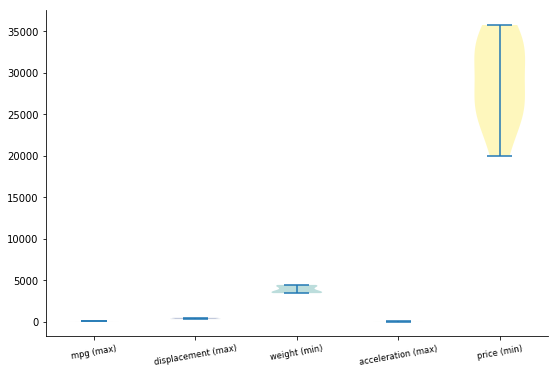

In [6]:
# some visualization -- diverse distribution and unit
criteria_data.plot("violin")

In [137]:
# (17/156) + (302/3749)+ (1/(3449/38797)) + (10.5/103) + (1/(20000/287872.33))

0.10897435897435898

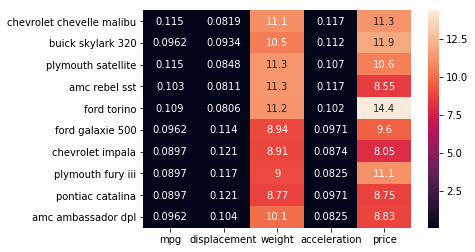

In [7]:
# Functions
def normalize_data(logic="minmax"):
  df = cars_data.iloc[:, 1:].values.copy()
  if logic == "minmax":
    normalized_data = minmax_scale(df)
    normalized_data[:, 2] = 1 - normalized_data[:, 2]
    normalized_data[:, 4] = 1 - normalized_data[:, 4]
  elif logic == "sumNorm":
    normalized_data = df / df.sum(axis=0)
    normalized_data[:, 2] = 1 / normalized_data[:, 2]
    normalized_data[:, 4] = 1 / normalized_data[:, 4]
  elif logic == "maxNorm":
    normalized_data = df / df.max(axis=0)
    normalized_data[:, 2] = 1 / normalized_data[:, 2]
    normalized_data[:, 4] = 1 / normalized_data[:, 4]
  return normalized_data

def plot_heatmap(logic="minmax"):
  plot_data = normalize_data(logic)
  car_model_names = cars_data['car_name']
  attribute_names = cars_data.columns[1:]
  sns.heatmap(plot_data, annot=True, yticklabels = car_model_names, xticklabels = attribute_names, fmt='.3g')
  #
plot_heatmap("sumNorm")
# normalize_data("maxNorm")

## Implementation

**Algorithms**:
1. WeightedSum
2. WeightedProduct
3. MinMax with subtract

**Package**: https://scikit-criteria.readthedocs.io/en/latest/

Generic steps in selected ranking algorithm,
1. Normalize the columns
$$
\underline{\text{Maximization}}\\
\text{Let A be an attribute which we want to maximize,}\\
\text{and its elements are: }\begin{bmatrix}a_1 & a_2 & ... & a_n\end{bmatrix};\space1 \le i \le n\\
\text{Then, }maximize(a_i) = maximizeFunc(a_i, A) \\
  \text{where, }
      maximizeFunc(a_i, A) = 
  \begin{cases}
      \frac{a_i}{sum(A)}, & \text{sum normalization }\\
      \frac{a_i}{max(A)}, & \text{max normalization }\\
      \frac{a_i - min(A)}{max(A) - min(A)}, & \text{max-min scaling}\\
      ...\\
  \end{cases}
$$

$$
\underline{\text{Minimization}}\\
\text{Let A be an attribute which we want to minimize,}\\
\text{and its elements are: }\begin{bmatrix}a_1 & a_2 & ... & a_n\end{bmatrix};\space1 \le i \le n\\
\text{Then, }minimize(a_i) = minimizeFunc(a_i, A) \\
  \text{where, }
      minimizeFunc(a_i, A) = 
  \begin{cases}
      \frac{1}{maximizeFunc(a_i, A)}, & \text{inverse}\\
      1-maximizeFunc(a_i, A), & \text{subtract}\\
      ...\\
  \end{cases}
$$
2. Apply the weights

$$
\underline{\text{Weight modification}}\\
\text{Let W denote a vector with weights for each attribute,}\\
\text{and its elements are: }\begin{bmatrix}w_1 & w_2 & ... & w_m\end{bmatrix};\space1 \le i \le m \\
modifyWeight(w_i)    = 
  \begin{cases}
      w_i, & \text{as it is }\\
      \frac{w_i}{sum(W)}, & \text{sum normalization }\\
      \frac{w_i}{max(W)}, & \text{max normalization }\\
      ...\\
  \end{cases}
$$
3. Calculate score

There are two important parameters in these functions, 
1. mnorm: normalizaton method for data matrix: sum or max, 
2. wnorm: normalization method for weights



## WeightedSum example

In [10]:
from skcriteria.madm import simple
# weighted sum
dm = simple.WeightedSum(mnorm="sum")
dec = dm.decide(criteria_data)
dec

WeightedSum (mnorm=sum, wnorm=sum) - Solution:
       ALT./CRIT.           mpg (max)    displacement (max)    weight (min)    acceleration (max)    price (min)    Rank
-------------------------  -----------  --------------------  --------------  --------------------  -------------  ------
chevrolet chevelle malibu      18               307                3504                12              25561.6       3
    buick skylark 320          15               350                3693               11.5             24221.4       2
   plymouth satellite          18               318                3436                11              27240.8       4
      amc rebel sst            16               304                3433                12               33685        6
       ford torino             17               302                3449               10.5              20000        1
    ford galaxie 500           15               429                4341                10               30000        8
    chevrolet impala           14               454                4354                9               35764.3       10
    plymouth fury iii          14               440                4312               8.5              25899.5       5
    pontiac catalina           14               455                4425                10              32882.5       9
   amc ambassador dpl          15               390                3850               8.5              32617.1       7

In [11]:
# export the final scores
dec.e_.points
# export the rank
# dec.rank_

array([22.6478868 , 22.69173895, 22.16599959, 20.14736576, 25.93384983,
       18.84075413, 17.25802042, 20.40206847, 17.83044267, 19.18566654])

In [12]:
# manual calculation of finla score of "Ford Torino", see element at index 4 of previous cell
(17/156) + (302/3749)+ (1/(3449/38797)) + (10.5/103) + (1/(20000/287872.33))

25.933855179935065

## Multiple runs with different solvers 

In [13]:
# import
from skcriteria.madm import simple

# make a copy of original dataset
cars_data_copy = cars_data.copy()

# weighted sum, sumNorm
dm = simple.WeightedSum(mnorm="sum")
dec = dm.decide(criteria_data)
cars_data_copy.loc[:, 'rank_weightedSum_sumNorm_inverse'] = dec.rank_

# weighted sum, maxNorm
dm = simple.WeightedSum(mnorm="max")
dec = dm.decide(criteria_data)
cars_data_copy.loc[:, 'rank_weightedSum_maxNorm_inverse'] = dec.rank_

# weighted product, sumNorm
dm = simple.WeightedProduct(mnorm="sum")
dec = dm.decide(criteria_data)
cars_data_copy.loc[:, 'rank_weightedProduct_sumNorm_inverse'] = dec.rank_

# weighted product, sumNorm
dm = simple.WeightedProduct(mnorm="max")
dec = dm.decide(criteria_data)
cars_data_copy.loc[:, 'rank_weightedProduct_maxNorm_inverse'] = dec.rank_

# min max scale + mirror
cars_data_copy.loc[:, 'rank_weightedSum_minmaxScale_subtract'] =\
     pd.Series(normalize_data().sum(axis=1)).rank(ascending=False).astype(int)

# sort for better visualization
cars_data_copy.sort_values(by=['rank_weightedSum_sumNorm_inverse'], inplace=True)

In [14]:
# plot
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure(data=
    go.Parcoords(
        dimensions = list([
            dict(label = 'Car name', range=[1, 10], 
                 tickvals = list(range(1, 11)),
                 values = list(range(1, 11)),
                 ticktext = cars_data_copy['car_name']),
            dict(label = 'WeightedSum(sum)', values = cars_data_copy['rank_weightedSum_sumNorm_inverse']),
            dict(label = 'WeightedSum(max)', values = cars_data_copy['rank_weightedSum_maxNorm_inverse']),
            dict(label = 'WeightedProduct(sum)', values = cars_data_copy['rank_weightedProduct_sumNorm_inverse']),
            dict(label = 'WeightedProduct(max)', values = cars_data_copy['rank_weightedProduct_maxNorm_inverse']),
            dict(label = 'MinMax_subtract', values = cars_data_copy['rank_weightedSum_minmaxScale_subtract']),

        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

# Appendix

## Example heatmaps

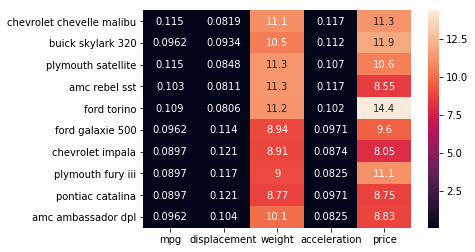

In [15]:
plot_heatmap("sumNorm")
# normalize_data("sumNorm").sum(axis=1)[:2]

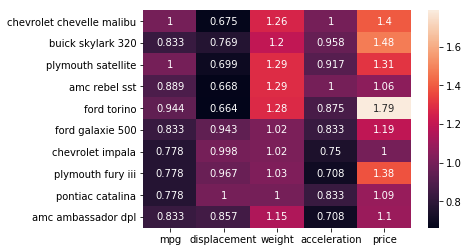

In [16]:
plot_heatmap("maxNorm")
# normalize_data("maxNorm").sum(axis=1)[:2]

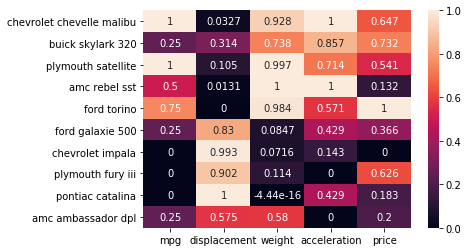

In [17]:
plot_heatmap("minmax")
# normalize_data("minmax").sum(axis=1)[:2]

## Compare the distribution of data after normalization

In [18]:
import numpy as np
x = np.array(range(1, 10))
print("X: ", x)
print("MinMax: ", minmax_scale(x))
print("MinMax_subtract: ", 1 - minmax_scale(x))
print("sumNorm: ", x/sum(x))
print("sumNorm_inverse: ", (1/(x/sum(x))))
print("maxNorm: ", x/max(x))
print("maxNorm_inverse: ", 1/(x/max(x)))

X:  [1 2 3 4 5 6 7 8 9]
MinMax:  [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
MinMax_subtract:  [1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
sumNorm:  [0.02222222 0.04444444 0.06666667 0.08888889 0.11111111 0.13333333
 0.15555556 0.17777778 0.2       ]
sumNorm_inverse:  [45.         22.5        15.         11.25        9.          7.5
  6.42857143  5.625       5.        ]
maxNorm:  [0.11111111 0.22222222 0.33333333 0.44444444 0.55555556 0.66666667
 0.77777778 0.88888889 1.        ]
maxNorm_inverse:  [9.         4.5        3.         2.25       1.8        1.5
 1.28571429 1.125      1.        ]
